<a href="https://colab.research.google.com/github/kaden-weber/260CreativeProject1/blob/master/FinalCensusData.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# lab 10 imports 
from torchvision.models import resnet152
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, Dataset
import torch
from torch import optim, nn
import zipfile
from google.colab import files
import os
import sys
from PIL import Image, ImageOps
from tqdm import tqdm
import numpy as np
from matplotlib import pyplot as plt


In [0]:
# style 

### Used to style Python print statements, 
    # from https://stackoverflow.com/users/1770999/boubakr via Patrick Stetz
class color:
    BOLD = '\033[1m'
    UNDERLINE = '\033[4m'
    END = '\033[0m'

In [0]:
# my imports
import pandas as pd
import torch.nn.functional as F
import random


In [4]:
# auth with kaggle
# Run this cell and select the kaggle.json file downloaded
# from the Kaggle account settings page.
from google.colab import files
files.upload()
# Next, install the Kaggle API client.
!pip install -q kaggle
# Let's make sure the kaggle.json file is present.
!ls -lha kaggle.json
# The Kaggle API client expects this file to be in ~/.kaggle,
# so move it there.
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
# This permissions change avoids a warning on Kaggle tool startup.
!chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
-rw-r--r-- 1 root root 66 Dec 17 21:04 kaggle.json


In [5]:
#download dataset
!kaggle datasets download -d muonneutrino/us-census-demographic-data

  0% 0.00/10.6M [00:00<?, ?B/s]
100% 10.6M/10.6M [00:00<00:00, 97.4MB/s]


In [6]:
# unzip and import with pandas

def extract_zip(zip_file, extract_dir):
  print("Extracting", zip_file)
  print("To", extract_dir)
  with zipfile.ZipFile(zip_file, 'r') as zip_ref:
      zip_ref.extractall(extract_dir)

def read(csv_path):
  return pd.read_csv(csv_path, encoding='latin-1')

def unzip_once():
  zip_file='/content/us-census-demographic-data.zip'
  extract_dir = os.path.splitext(zip_file)[0]
  if not os.path.exists(extract_dir):
    os.makedirs(extract_dir)
  extract_zip(zip_file, extract_dir)

unzip_once() 
county_2015 = read(
    '../content/us-census-demographic-data/acs2015_county_data.csv')
tract_2015 = read(
    '../content/us-census-demographic-data/acs2015_census_tract_data.csv')
county_2017 = read(
    '../content/us-census-demographic-data/acs2017_county_data.csv')
tract_2017 = read(
    '../content/us-census-demographic-data/acs2017_census_tract_data.csv')
data_2015 = (county_2015, tract_2015)
data_2017 = (county_2017, tract_2017)
data_all = (county_2015, tract_2015, county_2017, tract_2017)

Extracting /content/us-census-demographic-data.zip
To /content/us-census-demographic-data


In [7]:
# prep data 
# dropped = 0
# for csv in data_all:
#   len_before = len(csv)
#   csv = csv.drop(csv[csv.TotalPop == 0].index)
#   len_after = len(csv)
#   dropped += len_before - len_after

#   # if we had more time, we could add these back as a one hot incoding
#   csv = csv.drop(['State', 'County'], axis=1)

# print("Number of rows removed with zero population: {}{}{}".format(
#     color.BOLD, dropped, color.END))

# print("example entry:\n", data_all[1])

# tract_2015 = tract_2015.drop(tract_2015[tract_2015.TotalPop == 0].index)
tract_2015 = tract_2015.drop(['State', 'County'], axis=1)

# tract_2017 = tract_2017.drop(tract_2017[tract_2017.TotalPop == 0].index)
tract_2017 = tract_2017.drop(['State', 'County'], axis=1)

tract_2015 = tract_2015.dropna()
tract_2017 = tract_2017.dropna()

print(tract_2015)
print(tract_2017)
print(tract_2017.iloc[0])
# ensure rows match by ID, assume in order, just take out ones without a match

        # ex.  truth_data = torch.from_numpy(self.file_data.iloc[idx, 1:3].values.astype(np.float32))

# for row in range(len(tract_2015) - 1):
#   if tract_2015.iloc[row, 0] not in tract_2017.iloc[0]:
#     tract_2015 = tract_2015.drop([row])

# for row in range(len(tract_2017) -1 ):
#   if tract_2017.iloc[row, 0] not in tract_2015.iloc[0]:
#     tract_2017 = tract_2017.drop([row])

       CensusTract  TotalPop   Men  ...  SelfEmployed  FamilyWork  Unemployment
0       1001020100      1948   940  ...           4.6         0.0           5.4
1       1001020200      2156  1059  ...           6.1         0.0          13.3
2       1001020300      2968  1364  ...          12.3         0.0           6.2
3       1001020400      4423  2172  ...           3.1         0.0          10.8
4       1001020500     10763  4922  ...           5.3         0.0           4.2
...            ...       ...   ...  ...           ...         ...           ...
73996  72153750501      6205  3291  ...           3.9         0.0          21.3
73997  72153750502      2122   921  ...           3.3         0.0          22.4
73998  72153750503      2277  1097  ...           9.5         0.0          23.3
73999  72153750601      5267  2663  ...           1.3         0.0          26.7
74000  72153750602      2741  1181  ...           7.7         0.0          20.1

[72727 rows x 35 columns]
           Tr

In [0]:
# convert to tensors!  
# print('tract 15:\n', tract_2015.loc[0])
# tract_15_tensors = []
# for entry in tract_2015.values:
#   tract_15_tensors.append(torch.from_numpy(entry))
# print('tract 0:\n', tract_15_tensors[0])
# county_15_t = torch.from_numpy(county_2015.values)
# tract_15_t = torch.from_numpy(tract_2015.values)
# county_17_t = torch.from_numpy(county_2017.values)
# tract_17_t = torch.from_numpy(tract_2017.values)

In [9]:
#dataset

class USCensusTractDataset(Dataset):
  def __init__(self, start_tracts, end_tracts, train=True, upload=False):
    super(USCensusTractDataset, self).__init__()
    self.start_tracts = start_tracts
    self.end_tracts = end_tracts

    self.start_t = torch.from_numpy(start_tracts.values.astype(np.float32))
    self.end_t = torch.from_numpy(end_tracts.values.astype(np.float32))
    self.dataset = self.couple(self.start_t, self.end_t)
    # self.start_t = torch.from_numpy(start_tracts.values)
    # self.end_t = torch.from_numpy(end_tracts.values)

    self.train = train
    # do any data prep here

  def couple(self, start_t, end_t):
    coupledDataset = []
    for i in range(len(start_t)):
      row = start_t[i]
      start = i - 20
      if start < 0:
        start = 0
      stop = i + 20
      if stop >= len(end_t):
        stop = len(end_t - 1)
      match = self.findRowByID(end_t, start, stop, row[0])
      if match is not None:
        coupledDataset.append((row, match))
    return coupledDataset

  
  def findRowByID(self, tensor, start, stop, id):
    # id is first entry in row
    for i in range(start, stop):
      # print(row)
      # print(row[0])
      # print(id)
      if tensor[i, 0] == id:
        return tensor[i]
    return None

  def __getitem__(self, i):
    # start_data = self.start_t[i]
    # end_data = self.end_t[i]

    # if start_data[0] == end_data[0]:
    #   return start_data, end_data       
    # else:
    #   return start_data, self.findRowByID(self.end_t, start_data[0])
    return self.dataset[i]

  def __len__(self):
    # return len(self.start_t)
    return len(self.dataset)

#example dataset that imports pandas dataframe
class EventsDataset(Dataset):
    def __init__(self, root_folder, data_set_name, numrows = None, mns_file_name = None ):
        self.my_file_name = os.path.join( root_folder, data_set_name )
        file_data = pd.read_csv(self.my_file_name, nrows = numrows )
        self.tensor_data = torch.from_numpy( file_data.values.astype(np.float32)  )
        del file_data

    def __len__(self):
        return len(self.tensor_data)

    def __getitem__(self, idx):
        truth_data = self.tensor_data[idx, 1:3]
        recon_data = self.tensor_data[idx, 4:]
        return recon_data, truth_data


dataset = USCensusTractDataset(tract_2015, tract_2017)
item = dataset.__getitem__(0)
print(dataset.__len__())
print(item[0])
print(item[1])



72721
tensor([1.0010e+09, 1.9480e+03, 9.4000e+02, 1.0080e+03, 9.0000e-01, 8.7400e+01,
        7.7000e+00, 3.0000e-01, 6.0000e-01, 0.0000e+00, 1.5030e+03, 6.1838e+04,
        1.1900e+04, 2.5713e+04, 4.5480e+03, 8.1000e+00, 8.4000e+00, 3.4700e+01,
        1.7000e+01, 2.1300e+01, 1.1900e+01, 1.5200e+01, 9.0200e+01, 4.8000e+00,
        0.0000e+00, 5.0000e-01, 2.3000e+00, 2.1000e+00, 2.5000e+01, 9.4300e+02,
        7.7100e+01, 1.8300e+01, 4.6000e+00, 0.0000e+00, 5.4000e+00])
tensor([1.0010e+09, 1.8450e+03, 8.9900e+02, 9.4600e+02, 2.4000e+00, 8.6300e+01,
        5.2000e+00, 0.0000e+00, 1.2000e+00, 0.0000e+00, 1.4070e+03, 6.7826e+04,
        1.4560e+04, 3.3018e+04, 6.2940e+03, 1.0700e+01, 2.0800e+01, 3.8500e+01,
        1.5600e+01, 2.2800e+01, 1.0800e+01, 1.2400e+01, 9.4200e+01, 3.3000e+00,
        0.0000e+00, 5.0000e-01, 0.0000e+00, 2.1000e+00, 2.4500e+01, 8.8100e+02,
        7.4200e+01, 2.1200e+01, 4.5000e+00, 0.0000e+00, 4.6000e+00])


In [0]:
#network(s)

#mnist example (from similar csv)
class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(784, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 128)
        self.fc4 = nn.Linear(128, 10)
        self.dropout = nn.Dropout(p=0.2)
        
    def forward(self, x):
        x = x.view(x.shape[0], -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.dropout(F.relu(self.fc3(x)))
        x = F.log_softmax(self.fc4(x), dim=1)
        return x

class MyClassifier(nn.Module):
  def __init__(self):
    super().__init__()
    self.fc1 = nn.Linear(35, 70)
    # self.fc1.weight = torch.nn.Parameter(torch.ones(self.fc1.weight.size()))
    self.fc2 = nn.Linear(70, 140)
    # self.fc2.weight = torch.nn.Parameter(torch.ones(self.fc2.weight.size()))
    self.fc3 = nn.Linear(140, 70)
    # self.fc3.weight = torch.nn.Parameter(torch.ones(self.fc3.weight.size()))
    self.fc4 = nn.Linear(70, 35)
    # self.fc4.weight = torch.nn.Parameter(torch.ones(self.fc4.weight.size()))
    self.dropout = nn.Dropout(p=0.2)
      
  def forward(self, x):
      # x = x.view(x.shape[0], -1)
      x = F.relu(self.fc1(x))
      x = F.relu(self.fc2(x))
      x = self.dropout(F.relu(self.fc3(x)))
      x = self.fc4(x)
      
      return x

In [0]:
batch_size = 256 

# instantiate dataset
train_dataset = USCensusTractDataset(tract_2015, tract_2017)
# val_dataset = USCensusTractDataset(tract_2015, tract_2017)
train_loader = DataLoader(train_dataset, shuffle=True, batch_size=batch_size)
# val_loader = DataLoader(val_dataset, shuffle=True, batch_size=batch_size)

In [0]:
# training

epochs = 100
learning_rate = 0.003
val_every = 3
device = torch.device('cuda:0')

# model
row_size = 37 # number of columns in csv's
model = MyClassifier().to(device)

# objective = nn.CrossEntropyLoss()
objective = nn.L1Loss()
# objective = nn.NLLLoss()
# objective = nn.MSELoss()

optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [18]:
# Training Loop
pbar = tqdm(total=len(train_loader) * epochs)

train_losses = []
train_accs = []
val_losses = []
val_accs = []

count = 0 
for epoch in range(epochs):
  for x, y_truth in train_loader:
    x, y_truth = x.to(device), y_truth.to(device)

    optimizer.zero_grad()

    y_hat = model(x)
    train_loss = objective(y_hat, y_truth)
    # train_acc = accuracy(y_hat, y_truth)

    train_loss.backward()
    optimizer.step()

    # train_accs.append(train_acc)
    train_losses.append(train_loss.item())

    # if count % val_every == 0:
    #   val_loss, val_acc = evaluate(model, objective, val_loader, device)
    #   val_losses.append(val_loss)
    #   # val_accs.append(val_acc)
      
    pbar.set_description('train loss:{0:16.4f}'.format(train_loss.item()))
    pbar.update(1)

    count += 1

pbar.close()

train loss:  793867648.0000: 100%|██████████| 28500/28500 [02:57<00:00, 160.36it/s]


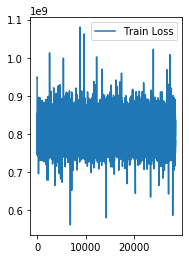

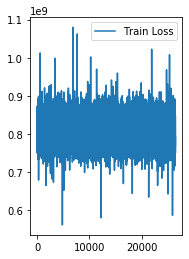

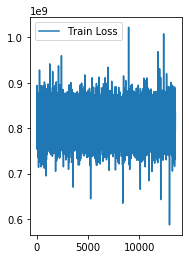

In [19]:
# display data
# plt.subplot(121)
# plt.plot(np.arange(len(train_accs)), train_accs, label='Train Accuracy')
# plt.plot(np.arange(len(train_accs), step=val_every), val_accs, label='Val accuracy')
# plt.legend()
plt.subplot(122)
plt.plot(np.arange(len(train_losses)), train_losses, label='Train Loss')
# plt.plot(np.arange(len(train_losses), step=val_every), val_losses, label='Val Loss')
plt.legend()
plt.show()

zoom = train_losses[2000:]
plt.subplot(122)
plt.plot(np.arange(len(zoom)), zoom, label='Train Loss')
plt.legend()
plt.show()

zoom2 = train_losses[15000:]
plt.subplot(122)
plt.plot(np.arange(len(zoom2)), zoom2, label='Train Loss')
plt.legend()
plt.show()


In [21]:
# validate
for _ in range(10):
  tract_index = random.randint(0, train_dataset.__len__())
  x, goal = train_dataset.__getitem__(tract_index)
  output = model(x.to(device))

  initial_pop = int(x[1])
  final_pop = int(goal[1])
  est_pop = int(output[1])
  actual_population_change = final_pop - initial_pop
  predicted_population_change = est_pop - initial_pop
  print('\nTract:', int(x[0]))
  print('beginning =', initial_pop)
  print('end       =', final_pop)
  print('actual population change     =', actual_population_change)
  print('predicted population change  =', predicted_population_change)


Tract: 9003511808
beginning = 2495
end       = 3775
actual population change     = 1280
predicted population change  = -2410

Tract: 47157002240
beginning = 3724
end       = 1985
actual population change     = -1739
predicted population change  = -3639

Tract: 26111291392
beginning = 4453
end       = 2302
actual population change     = -2151
predicted population change  = -4368

Tract: 42071015424
beginning = 4667
end       = 3140
actual population change     = -1527
predicted population change  = -4582

Tract: 20173010944
beginning = 13061
end       = 4151
actual population change     = -8910
predicted population change  = -12976

Tract: 36103122944
beginning = 6562
end       = 5815
actual population change     = -747
predicted population change  = -6477

Tract: 36077588480
beginning = 3832
end       = 4537
actual population change     = 705
predicted population change  = -3747

Tract: 53035089920
beginning = 3375
end       = 5232
actual population change     = 1857
predicted populat

In [0]:
# trash can! 

# define loss

class ForecastLoss(nn.Module):
    def __init__(self, target_feature):
        super(ForecastLoss, self).__init__()
        
        # detach to ensure we don't back prop into our gram matrix
        self.target = gram_matrix(target_feature).detach()

    def forward(self, input):
        G = gram_matrix(input)
        
        # mean squared error between the gram matricies of our style image and the input image
        self.loss = F.mse_loss(G, self.target)

        return input

#training helper functions
# def accuracy(y_hat, y_truth):
#     """Gets average accuracy of a vector of predictions"""
    
#     # preds = torch.argmax(y_hat, dim=1)
#     # acc = torch.mean((preds == y_truth).float())
#     # trying to just get average difference
#     acc = torch.mean(y_truth.sub(y_hat))
#     return acc

def evaluate(model, objective, val_loader, device):
    """Gets average accuracy and loss for the validation set"""

    val_losses = []
    val_accs = []
    # model.eval() so that batchnorm and dropout work in eval mode
    model.eval()
    # torch.no_grad() to turn off computation graph creation. This allows for temporal
    # and spatial complexity improvements, which allows for larger validation batch 
    # sizes so it’s recommended
    with torch.no_grad():
        for x, y_truth in val_loader:

            x, y_truth = x.to(device), y_truth.to(device)
            y_hat = model(x)
            print(y_hat)
            print(y_truth)
            val_loss = objective(y_hat, y_truth)
            # val_acc = accuracy(y_hat, y_truth)

            val_losses.append(val_loss.item())
            # val_accs.append(val_acc)

    model.train()

    return torch.mean(torch.Tensor(val_losses)), torch.mean(torch.Tensor(val_accs))